In [9]:
setwd('/import/liujing/data/my')

In [10]:
load('../expr.rda')

In [11]:
library(dplyr)

In [12]:
colnames(expr) = gsub('-','.',colnames(expr))

In [13]:
#expr2 = expr2[,c(1:18)]

In [14]:
head(expr,2)

,RASD2,HIST1H3C,TMEM92,CEP55,TPM3,HIST1H1B,AC132872.2,MIF,HJURP,BUB1,...,PDCD1LG2,MANSC1,RPS28,PLP2,SGOL1,CCNA2,SAP130,CEACAM1,F5,CMTM1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CI10,0,8.715837,0.2093388,0.4297173,41.74707,29.22072,0.1386199,0.8774675,0.3114319,1.0037990,...,6.617980,3.640068,85.49359,65.47431,0.9050358,1.295008,11.37361,6.018822,8.073764,23.14300
CI11,0,5.598192,0.1934709,0.1702049,64.47738,16.91363,0.6588642,0.5020200,0.2691354,0.7028831,...,1.027261,15.546800,115.56397,95.79803,0.4480897,0.888065,14.02403,15.381449,12.007841,43.23487


In [15]:
Type

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[77] 0 0 0 0 0 0 0 0 0

In [19]:
expr = expr

In [20]:
x = as.matrix(expr)
y = Type

In [21]:
library(randomForest)

Warning message:
"package 'randomForest' was built under R version 4.2.3"
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine




In [46]:
options(repr.plot.width = 6)

In [50]:
set.seed(111)

In [51]:
rf = randomForest(as.factor(y)~.,data = x,ntree =1000,important=TRUE,proximity=TRUE)

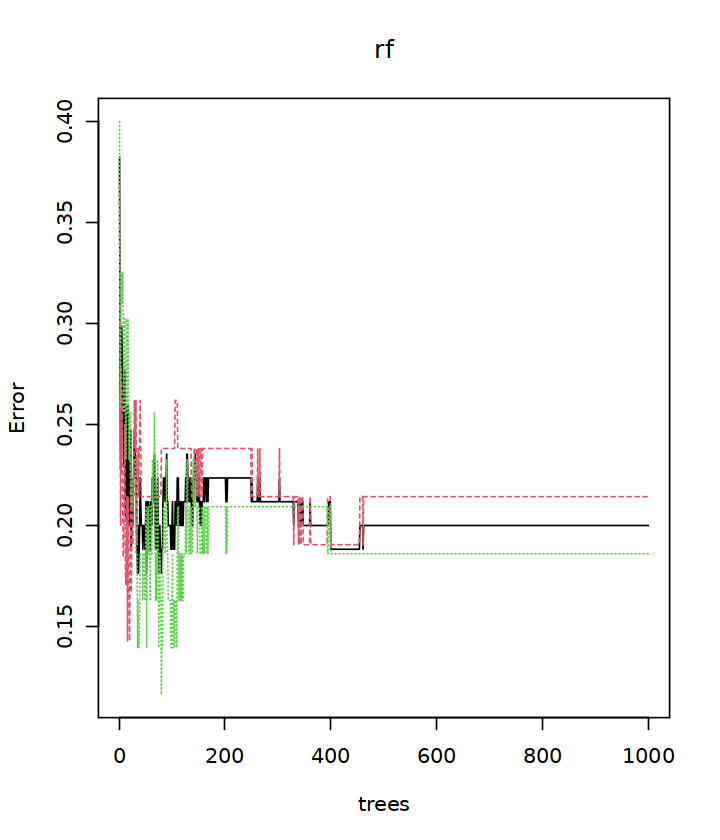

In [52]:
plot(rf)

In [53]:
pdf('forest.pdf',height = 6,width = 6)
plot(rf)
dev.off()

png 
  2

In [54]:
trees = which.min(rf$err.rate[,1])

In [55]:
rf = randomForest(as.factor(y)~.,data = x,ntree =trees,important=TRUE,proximity=TRUE)

In [56]:
importance = importance(rf)

In [57]:
pdf('forest2.pdf',height = 6,width = 4)
varImpPlot(rf,main = '')
dev.off()

png 
  2

In [58]:
# RPE65 + MC3R+NFIL3 + PRF1 + IL6

In [59]:
options(repr.plot.width = 4)

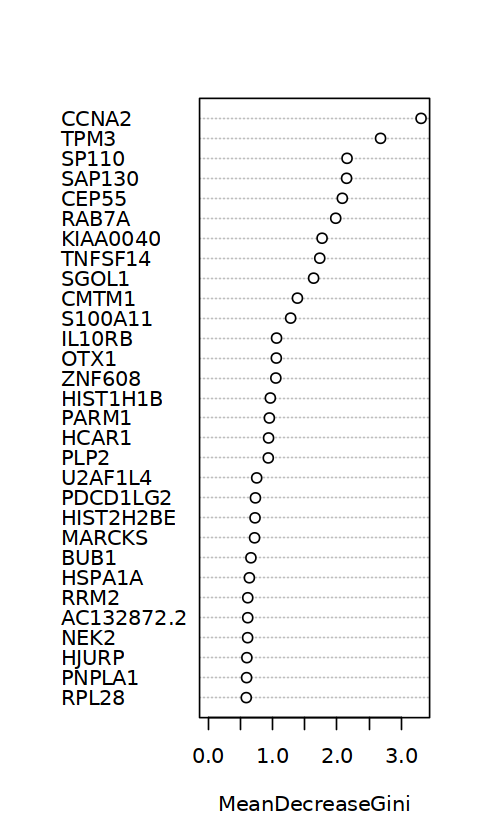

In [60]:
varImpPlot(rf,main = '')

In [61]:
rfGenes=importance[order(importance[, "MeanDecreaseGini"], decreasing  = TRUE),] #重要性评分大于2的基因

In [62]:
rfGenes

CCNA2       TPM3      SP110     SAP130      CEP55      RAB7A   KIAA0040 
3.30472006 2.67606534 2.15594827 2.14902178 2.08269517 1.98033080 1.76876843 
   TNFSF14      SGOL1      CMTM1    S100A11     IL10RB       OTX1     ZNF608 
1.73258215 1.63733758 1.38604221 1.28104158 1.06224625 1.05871491 1.05123138 
  HIST1H1B      PARM1      HCAR1       PLP2    U2AF1L4   PDCD1LG2  HIST2H2BE 
0.96593442 0.95082562 0.93832868 0.93404237 0.75420217 0.73433073 0.72845745 
    MARCKS       BUB1     HSPA1A       RRM2 AC132872.2       NEK2      HJURP 
0.72145873 0.66459236 0.64064904 0.61551887 0.61511530 0.61343498 0.60152587 
    PNPLA1      RPL28       TSHR  HIST1H2BM       TLR5      CKAP4    CEACAM1 
0.59765078 0.59261031 0.48010466 0.41344383 0.40997809 0.39848175 0.38836517 
   SLC26A8      RPS28         F5        MIF      GPR84    TNFSF15      PRRG4 
0.38510658 0.35980322 0.32855602 0.32806294 0.32728512 0.27048574 0.23038156 
    TMEM92      RASD2       MZB1   HIST1H3C     MANSC1    CCDC147 
0.21622323 0.16946779 0.16118367 0.10620164 0.08725439 0.05242630

In [63]:
rfGenes=names(rfGenes[rfGenes>30]) 
write.table(rfGenes,file="rfGenes.txt",sep="\t",quote=F,col.names=F,row.names=F) #输出表达量

In [64]:
sigExp=expr[rfGenes,]
write.table(data.frame(ID=rownames(sigExp),sigExp),file="rfGeneExp.txt",sep="\t",quote=F,col.names=T,row.names=F) 

### svm

In [65]:
library(tidyverse)
library(glmnet)
library(VennDiagram)
library(e1071)
library(caret)
library(randomForest)

In [66]:
y=as.numeric(as.factor(Type))

In [67]:
library(future)
plan("multisession",workers=30)

In [68]:
set.seed(1)
rfeControl = rfeControl(functions = caretFuncs,
                        method = "cv", # 默认自助法重采样 boot
                        saveDetails = T, # 保存预测值和变量重要性
                        number = 5, # 重抽样次数
                        allowParallel = T # 允许多线程，用这个之前你要先准备好多线程！
                        )

In [69]:
Profile=rfe(x=x,y=y,sizes = c(1:10),
    rfeControl =  rfeControl,
    methods="svmRadial")

Warning message in train.default(x, y, ...):
"You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column."
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

In [70]:
pdf(file="SVM-RFE.pdf", width=6, height=5.5)
par(las=1)
x= Profile$results$Variables 
y =Profile$results$RMSE
plot(x, y, xlab="Variables", ylab="RMSE (Cross-Validation)", col="darkgreen") 
lines(x, y, col="darkgreen")
wmin=which.min(y) 
wmin.x=x[wmin] 
wmin.y=y[wmin]
points(wmin.x, wmin.y, col="blue", pch=16)
text(wmin.x, wmin.y, paste0('N=', wmin.x), pos=2, col=2)
dev.off()

png 
  2

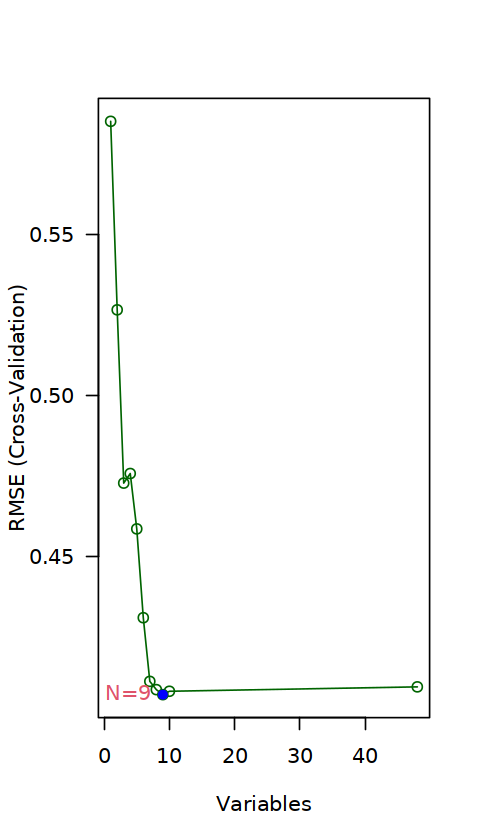

In [71]:
par(las=1)
x= Profile$results$Variables 
y =Profile$results$RMSE
plot(x, y, xlab="Variables", ylab="RMSE (Cross-Validation)", col="darkgreen") 
lines(x, y, col="darkgreen")
wmin=which.min(y) 
wmin.x=x[wmin] 
wmin.y=y[wmin]
points(wmin.x, wmin.y, col="blue", pch=16)
text(wmin.x, wmin.y, paste0('N=', wmin.x), pos=2, col=2)

In [72]:
#输出
featureGenes = Profile$optVariables
write.table(file="SVM-RFE.gene.txt",featureGenes,sep="\t",quote=F,row.names=F,col.names=F) #表达矩阵 

In [73]:
featureGenes

[1] "TPM3"       "SAP130"     "CCNA2"      "SP110"      "RAB7A"     
[6] "TNFSF14"    "NEK2"       "TLR5"       "AC132872.2"

### Boruta

In [74]:
library(Boruta)

In [75]:
x = as.matrix(expr)
y = Type

In [76]:
set.seed(1)
boruta <- Boruta(x=x, y=y, pValue=0.05, mcAdj=T, 
       maxRuns=300)

In [77]:
boruta

Boruta performed 299 iterations in 13.98855 secs.
 15 attributes confirmed important: AC132872.2, CCNA2, CEP55, CMTM1,
IL10RB and 10 more;
 30 attributes confirmed unimportant: BUB1, CCDC147, CEACAM1, CKAP4, F5
and 25 more;
 3 tentative attributes left: MARCKS, TSHR, ZNF608;

In [78]:
table(boruta$finalDecision)


Tentative Confirmed  Rejected 
        3        15        30 

In [79]:
boruta$finalDecision

RASD2   HIST1H3C     TMEM92      CEP55       TPM3   HIST1H1B AC132872.2 
  Rejected   Rejected   Rejected  Confirmed  Confirmed   Rejected  Confirmed 
       MIF      HJURP       BUB1     IL10RB  HIST2H2BE      GPR84    CCDC147 
  Rejected   Rejected   Rejected  Confirmed   Rejected   Rejected   Rejected 
   U2AF1L4      SP110       NEK2      PRRG4    SLC26A8      RAB7A      CKAP4 
  Rejected  Confirmed  Confirmed   Rejected   Rejected  Confirmed   Rejected 
    ZNF608     MARCKS       RRM2     PNPLA1    S100A11      HCAR1     HSPA1A 
 Tentative  Tentative   Rejected   Rejected  Confirmed   Rejected   Rejected 
      TLR5    TNFSF14    TNFSF15      PARM1       TSHR  HIST1H2BM      RPL28 
 Confirmed  Confirmed   Rejected   Rejected  Tentative   Rejected   Rejected 
      MZB1       OTX1   KIAA0040   PDCD1LG2     MANSC1      RPS28       PLP2 
  Rejected   Rejected  Confirmed   Rejected   Rejected   Rejected  Confirmed 
     SGOL1      CCNA2     SAP130    CEACAM1         F5      CMTM1 
  Rejected  Confirmed  Confirmed   Rejected   Rejected  Confirmed 
Levels: Tentative Confirmed Rejected

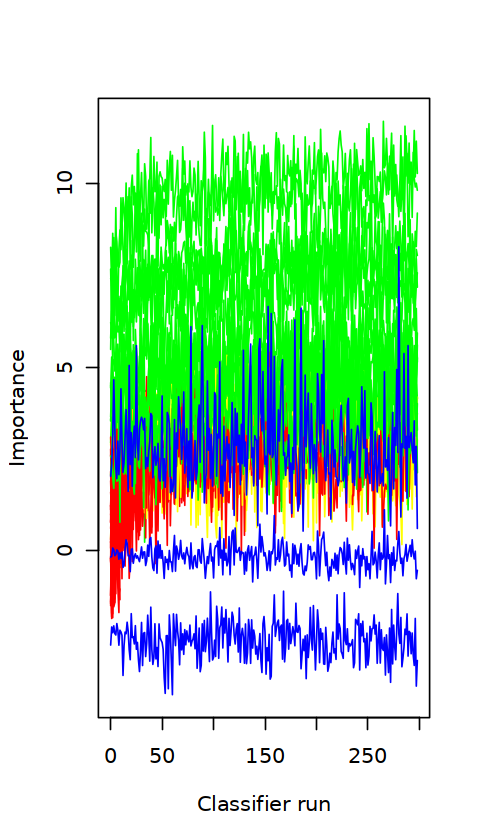

In [80]:
Boruta::plotImpHistory(boruta)

In [81]:
library(dplyr)
boruta.imp <- function(x){
  imp <- reshape2::melt(x$ImpHistory, na.rm=T)[,-1]
  colnames(imp) <- c("Variable","Importance")
  imp <- imp[is.finite(imp$Importance),]

  variableGrp <- data.frame(Variable=names(x$finalDecision), 
                            finalDecision=x$finalDecision)

  showGrp <- data.frame(Variable=c("shadowMax", "shadowMean", "shadowMin"),
                        finalDecision=c("shadowMax", "shadowMean", "shadowMin"))

  variableGrp <- rbind(variableGrp, showGrp)

  boruta.variable.imp <- merge(imp, variableGrp, all.x=T)

  sortedVariable <- boruta.variable.imp %>% group_by(Variable) %>% 
    summarise(median=median(Importance)) %>% arrange(median)
  sortedVariable <- as.vector(sortedVariable$Variable)


  boruta.variable.imp$Variable <- factor(boruta.variable.imp$Variable, levels=sortedVariable)

  invisible(boruta.variable.imp)
}
boruta.variable.imp <- boruta.imp(boruta)


Welcome to YSX package which is a collection of useful scripts.
This package does not require you install all depended packages, since one may not need all functions in this package.
However, when there is a message implying some functions are missing,please install these packages manually.
Or more specially, check Plot.Rmd in vignettes first.




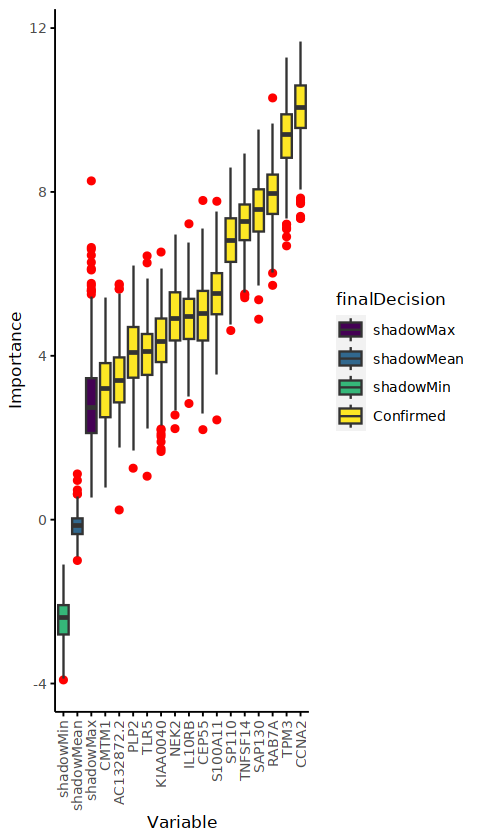

In [82]:
library(YSX)

sp_boxplot(boruta.variable.imp, melted=T, xvariable = "Variable", yvariable = "Importance",
           legend_variable = "finalDecision", legend_variable_order = c("shadowMax", "shadowMean", "shadowMin", "Confirmed"),
           xtics_angle = 90)

In [83]:
Group = data.frame(Group =  c(rep('CI',43),rep('H',42)))

In [272]:
expr3 = cbind(Group,expr)

In [85]:
set.seed(157)  
index <-  which( (1:nrow(expr3))%%3 == 0 )
train <- expr3[-index,]
test <- expr3[index,]

In [86]:
table(test$Group)


CI  H 
14 14 

In [87]:
library("xgboost")
library("Matrix")
train_matrix <- sparse.model.matrix(Group ~ .-1, data = train)
test_matrix <- sparse.model.matrix(Group ~ .-1, data = test)
all_matrix <- sparse.model.matrix(Group ~ .-1, data = expr3)


Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




In [88]:
train_label <- as.numeric(train$Group == 'CI')
test_label <-  as.numeric(test$Group == 'CI')
all_label <-  as.numeric(expr3$Group == 'CI')

In [89]:
all_label

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[77] 0 0 0 0 0 0 0 0 0

In [90]:
train_fin <- list(data=train_matrix,label=train_label) 
test_fin <- list(data=test_matrix,label=test_label) 
all_fin <- list(data=all_matrix,label=all_label) 

dtrain <- xgb.DMatrix(data = train_fin$data, label = train_fin$label) 
dtest <- xgb.DMatrix(data = test_fin$data, label = test_fin$label)
dall <- xgb.DMatrix(data = all_fin$data, label = all_fin$label)

In [91]:
xgb <- xgboost(data = dall,max_depth=6, eta=0.5,  
  objective='binary:logistic', nround=25)

[1]	train-logloss:0.448973 
[2]	train-logloss:0.303313 
[3]	train-logloss:0.227520 
[4]	train-logloss:0.178785 
[5]	train-logloss:0.140498 
[6]	train-logloss:0.119429 
[7]	train-logloss:0.098413 
[8]	train-logloss:0.084174 
[9]	train-logloss:0.075727 
[10]	train-logloss:0.067084 
[11]	train-logloss:0.061709 
[12]	train-logloss:0.056836 
[13]	train-logloss:0.052402 
[14]	train-logloss:0.049248 
[15]	train-logloss:0.047678 
[16]	train-logloss:0.046217 
[17]	train-logloss:0.044858 
[18]	train-logloss:0.043588 
[19]	train-logloss:0.041533 
[20]	train-logloss:0.039494 
[21]	train-logloss:0.038407 
[22]	train-logloss:0.037361 
[23]	train-logloss:0.036398 
[24]	train-logloss:0.035533 
[25]	train-logloss:0.034731 


In [92]:
xgb

##### xgb.Booster
raw: 25.3 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, max_depth = 6, eta = 0.5, objective = "binary:logistic")
params (as set within xgb.train):
  max_depth = "6", eta = "0.5", objective = "binary:logistic", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
# of features: 48 
niter: 25
nfeatures : 48 
evaluation_log:
    iter train_logloss
       1    0.44897278
       2    0.30331284
---                   
      24    0.03553268
      25    0.03473082

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
TPM3,0.24924634,0.14858879,0.09090909
CCNA2,0.13152400,0.12347643,0.09090909
AC132872.2,0.09530687,0.06710477,0.06060606
S100A11,0.09094233,0.05190727,0.04545455
TLR5,0.07714131,0.09908098,0.09090909
RAB7A,0.05812438,0.03577483,0.03030303


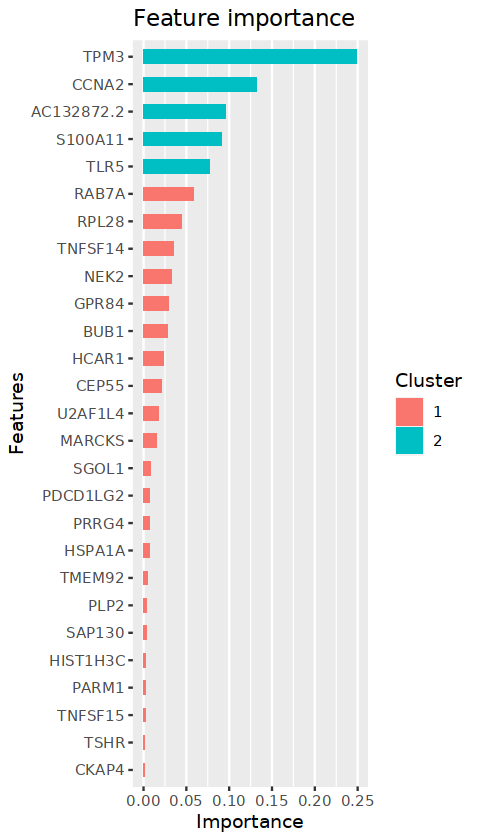

In [93]:
importance <- xgb.importance(all_matrix@Dimnames[[2]], model = xgb)  
head(importance)
xgb.ggplot.importance(importance)

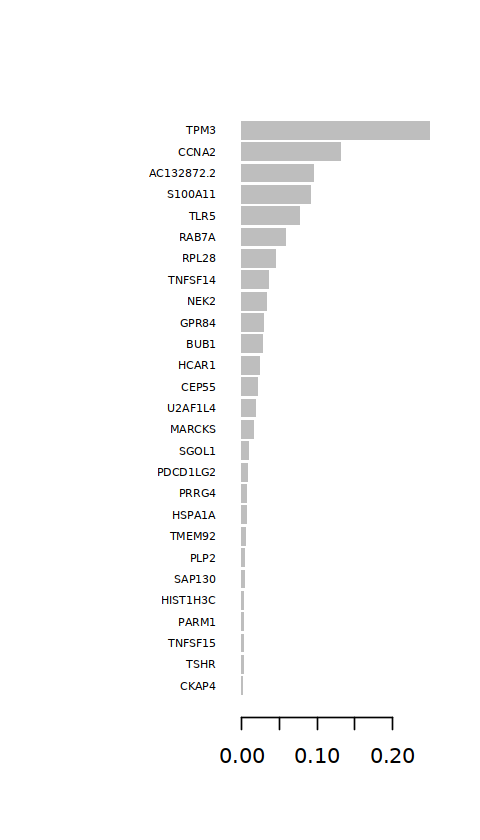

In [94]:
xgb.plot.importance(importance)

### 韦恩图

In [140]:
XGBoost.gene

[1] "TPM3"       "CCNA2"      "AC132872.2" "S100A11"    "TLR5"      
 [6] "RAB7A"      "RPL28"      "TNFSF14"    "NEK2"       "GPR84"     
[11] "BUB1"       "HCAR1"      "CEP55"      "U2AF1L4"    "MARCKS"    
[16] "SGOL1"      "PDCD1LG2"   "PRRG4"      "HSPA1A"     "TMEM92"    
[21] "PLP2"       "SAP130"     "HIST1H3C"   "PARM1"      "TNFSF15"   
[26] "TSHR"       "CKAP4"

In [95]:
RF.gene = colnames(sigExp)
#SVF.RFE.gene = featureGenes
XGBoost.gene = importance$Feature

In [96]:
boruta.variable.imp2 = boruta.variable.imp %>% dplyr::filter(finalDecision %in% c('Confirmed')) %>% dplyr::select(Variable) %>% unique()

In [97]:
Boruta.gene = as.vector(boruta.variable.imp2$Variable)

In [261]:
list1 = list(Boruta.gene,XGBoost.gene) #SVF.RFE.gene, RF.gene,

In [262]:
data =  as.data.frame (do.call (cbind, list1))

Warning message in (function (..., deparse.level = 1) :
"number of rows of result is not a multiple of vector length (arg 1)"


In [265]:

library(venn)
        library(VennDiagram)
        color=c( "#3C5488B2","#00A087B2", 
             "#F39B7FB2","#91D1C2B2", 
             "#8491B4B2", "#DC0000B2", 
             "#7E6148B2","yellow", 
             "darkolivegreen1", "lightskyblue", 
             "darkgreen", "deeppink", "khaki2", 
             "firebrick", "brown1", "darkorange1", 
             "cyan1", "royalblue4", "darksalmon", 
             "darkgoldenrod1", "darkseagreen", "darkorchid")

    if (ncol(data) == 2){
        sample_list <- list(Boruta.gene = data[,1], XGBoost.gene = data[,2])
    }else if(ncol(data) == 3){
        sample_list <- list(RF.gene = data[,1], Boruta.gene = data[,2], XGBoost.gene = data[,3])
    }else if(ncol(data) == 4){
        sample_list <- list(RF.gene = data[,1], SVF.RFE.gene = data[,2], Boruta.gene = data[,3], XGBoost.gene = data[,4])
    }else{
        sample_list <- list(c1 = data[,1], c2 = data[,2], c3 = data[,3], c4 = data[,4], c5 = data[,5])
    }
    
    q <- venn.diagram(sample_list,filename = NULL,
             fill = color[1:(length(sample_list))],
             alpha = 0.50, cat.col = rep('black', ncol(data)), 
             col = 'black', cex = 1, fontfamily = 'serif', cat.cex = 1, cat.fontfamily = 'serif', margin = 0.2
                             )
    pdf(paste0('./',"venn.pdf"))
    grid.draw(q)
    dev.off()

png 
  2

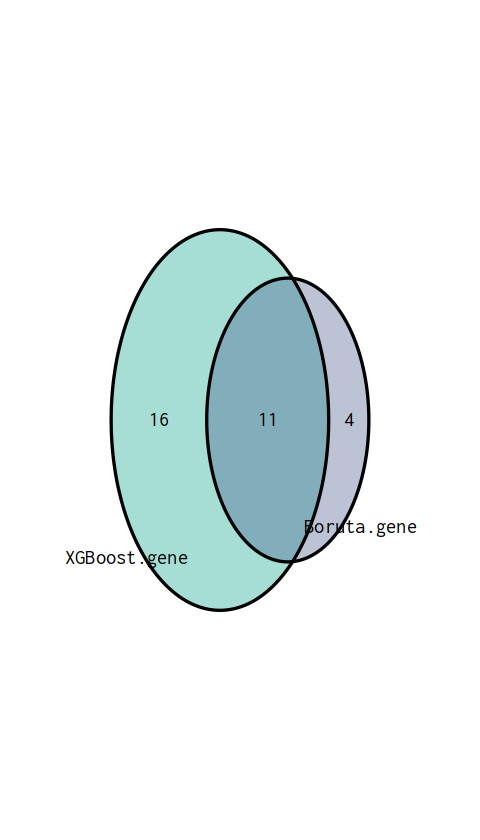

In [266]:
grid.draw(q)

In [267]:
model.gene = intersect(intersect(RF.gene,XGBoost.gene),Boruta.gene)#,SVF.RFE.gene

In [268]:
model.gene

[1] "CEP55"      "TPM3"       "AC132872.2" "NEK2"       "RAB7A"     
 [6] "S100A11"    "TLR5"       "TNFSF14"    "PLP2"       "CCNA2"     
[11] "SAP130"

In [273]:
set.seed(1234)

In [274]:
expr3[expr3$Group =='CI',]$Group<-1

In [275]:

expr3[expr3$Group =='H',]$Group<-0
expr3$Group = as.numeric(expr3$Group)

In [276]:
expr4 = expr3 %>% dplyr::select(c(Group,model.gene))

In [277]:
dim(expr4)

[1] 85 12

In [278]:
head(expr4,4)

,Group,CEP55,TPM3,AC132872.2,NEK2,RAB7A,S100A11,TLR5,TNFSF14,PLP2,CCNA2,SAP130
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CI10,1,0.42971733,41.74707,0.1386199,0.16073859,67.89057,323.0984,10.565927,12.36658,65.47431,1.2950078,11.37361
CI11,1,0.17020490,64.47738,0.6588642,0.07074029,141.57698,726.7223,7.743885,25.26063,95.79803,0.8880650,14.02403
CI12,1,0.06077068,64.28944,0.2548473,0.14775586,122.87541,1275.2671,9.808689,30.05067,123.90779,1.3325497,17.34162
CI13,1,0.03325148,54.30477,0.8924357,0.12576135,109.86647,1315.7439,28.050816,34.68924,105.23646,0.8360602,13.21951


In [279]:
library(caret)
library(ggplot2)

### 这里使用48个基因先看看情况



In [280]:
for (i in model.gene){
    res<-pROC::roc(Group~expr4[,i],data=expr4,aur=TRUE,
         ci=TRUE, # 显示95%CI
         #percent=TRUE, # 是否需要以百分比显示
         smooth=FALSE,# 是否平滑曲线
         levels=c(0,1),direction="<" #设置分组方向
         )
    if (res$auc > 0.5){
        print(res$auc)
        p = pROC::ggroc(res, color ="red",legacy.axes = TRUE)+
  geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), color="darkgrey", linetype=4)+
  theme_bw() + # 设置背景
  ggtitle(paste0(i," ROC Curve"))+
  theme(plot.title = element_text(hjust = 0.5,size = 16),
        axis.text=element_text(size=12,colour = "black"),
        axis.title.x = element_text(size = 14),
        axis.title.y = element_text(size = 14))
p+annotate("text",x=0.75,y=0.25,label=paste("AUC = ", round(res$auc,3)))+
  annotate("text",x=0.75,y=0.20,label=paste("95%CI: ", round(res$ci[1],3),'-',round(res$ci[3],3)))
    ggsave(file = paste0(i,'.ROC.pdf'))
}else{
        
}

    
    }

Area under the curve: 0.6573


Saving 6.67 x 6.67 in image


Area under the curve: 0.8128


Saving 6.67 x 6.67 in image


Area under the curve: 0.7254


Saving 6.67 x 6.67 in image


Area under the curve: 0.6955


Saving 6.67 x 6.67 in image


Area under the curve: 0.8095


Saving 6.67 x 6.67 in image


Area under the curve: 0.7082


Saving 6.67 x 6.67 in image


Area under the curve: 0.7126


Saving 6.67 x 6.67 in image


Area under the curve: 0.7132


Saving 6.67 x 6.67 in image


Area under the curve: 0.7126


Saving 6.67 x 6.67 in image


Area under the curve: 0.7951


Saving 6.67 x 6.67 in image


Area under the curve: 0.7852


Saving 6.67 x 6.67 in image


### 批量单因素逻辑回归

In [ ]:
#expr4 = expr3

In [281]:
#结果合并需要的包
library(plyr)
#可进行logistic回归的包
library(rms)#可实现逻辑回归模型（lrm）
library(epiDisplay)#快速输出OR、95%CI、P
#library(gtsummary)#精美三线表（但，95%CI有误）

In [282]:
varsU<-names(expr4[,2:dim(expr4)[2]])

In [283]:
Result<-c()
for (i in 1:length(varsU)){
  fit<-glm(substitute(Group~x,list(x=as.name(varsU[i]))),data=expr4,family=binomial())
  fitSum<-summary(fit)
  result1<-c()
  result1<-rbind(result1,fitSum$coef)
  OR<-exp(fitSum$coef[,'Estimate'])
  result1<-data.frame(cbind(result1,cbind(OR,exp(confint(fit)))))
  result1$Characteristics<-varsU[i]   #添加变量名
  Result<-rbind(Result,result1[-1,])#[-1,],删除常数项
}

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...



In [284]:
Result

,Estimate,Std..Error,z.value,Pr...z..,OR,X2.5..,X97.5..,Characteristics
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CEP55,6.629090760,2.370876883,2.796050,5.173137e-03,7.567938e+02,9.709188,1.149193e+05,CEP55
TPM3,0.116327706,0.029392639,3.957716,7.566998e-05,1.123364e+00,1.066163,1.197379e+00,TPM3
AC132872.2,2.977704702,0.930685162,3.199476,1.376777e-03,1.964268e+01,3.645186,1.434422e+02,AC132872.2
NEK2,11.869950248,3.841837814,3.089654,2.003897e-03,1.429071e+05,128.683274,4.927882e+08,NEK2
RAB7A,0.084679184,0.021588148,3.922485,8.764038e-05,1.088368e+00,1.047734,1.140741e+00,RAB7A
S100A11,0.004577771,0.001525695,3.000450,2.695807e-03,1.004588e+00,1.001874,1.007902e+00,S100A11
TLR5,0.131678502,0.059300494,2.220530,2.638284e-02,1.140742e+00,1.028549,1.300349e+00,TLR5
TNFSF14,0.186738650,0.054442264,3.430031,6.035125e-04,1.205312e+00,1.092556,1.355103e+00,TNFSF14
PLP2,0.042854298,0.014895926,2.876914,4.015850e-03,1.043786e+00,1.016077,1.077498e+00,PLP2


In [285]:
Uni_log<-data.frame(Result[,c(1,4:8)]) #提取"P","OR","CIlower","CIupper"和变量名

colnames(Uni_log)[2:5]<-c("P","OR","CIlower","CIupper")#变量重命名

ExtractVar<-unique(Uni_log$Characteristics[Uni_log$"P"<0.05]) 

In [286]:
tzgene = Uni_log %>% dplyr::filter(P < 0.05) %>% rownames()

In [287]:
Uni_log[tzgene,]

,Estimate,P,OR,CIlower,CIupper,Characteristics
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CEP55,6.629090760,5.173137e-03,7.567938e+02,9.709188,1.149193e+05,CEP55
TPM3,0.116327706,7.566998e-05,1.123364e+00,1.066163,1.197379e+00,TPM3
AC132872.2,2.977704702,1.376777e-03,1.964268e+01,3.645186,1.434422e+02,AC132872.2
NEK2,11.869950248,2.003897e-03,1.429071e+05,128.683274,4.927882e+08,NEK2
RAB7A,0.084679184,8.764038e-05,1.088368e+00,1.047734,1.140741e+00,RAB7A
S100A11,0.004577771,2.695807e-03,1.004588e+00,1.001874,1.007902e+00,S100A11
TLR5,0.131678502,2.638284e-02,1.140742e+00,1.028549,1.300349e+00,TLR5
TNFSF14,0.186738650,6.035125e-04,1.205312e+00,1.092556,1.355103e+00,TNFSF14
PLP2,0.042854298,4.015850e-03,1.043786e+00,1.016077,1.077498e+00,PLP2


### 多因素分析

In [288]:
tzgene

[1] "CEP55"      "TPM3"       "AC132872.2" "NEK2"       "RAB7A"     
 [6] "S100A11"    "TLR5"       "TNFSF14"    "PLP2"       "CCNA2"     
[11] "SAP130"

In [289]:
#tzgene1 = tzgene[-5]

In [290]:
data = expr4[,c('Group',tzgene)]
data$Group = factor(data$Group,levels = c(1,0))

In [291]:
fit.reduce<-glm(Group~.,data=data,family=binomial())
summary(fit.reduce)


Call:
glm(formula = Group ~ ., family = binomial(), data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.42616  -0.29255  -0.00004   0.27345   1.78661  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  24.042340   6.625496   3.629 0.000285 ***
CEP55        -3.706616   4.155010  -0.892 0.372348    
TPM3         -0.055148   0.072004  -0.766 0.443737    
AC132872.2   -3.125239   1.852643  -1.687 0.091621 .  
NEK2        -17.845650   8.267564  -2.159 0.030888 *  
RAB7A        -0.022050   0.052033  -0.424 0.671737    
S100A11       0.001552   0.004660   0.333 0.739175    
TLR5         -0.028910   0.114287  -0.253 0.800297    
TNFSF14      -0.217224   0.140677  -1.544 0.122557    
PLP2         -0.028375   0.050321  -0.564 0.572839    
CCNA2        -3.168781   1.354557  -2.339 0.019317 *  
SAP130       -0.352371   0.329541  -1.069 0.284944    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion 

In [292]:
logit.step <- step(fit.reduce,direction='both')
summary(logit.step)

Start:  AIC=70.59
Group ~ CEP55 + TPM3 + AC132872.2 + NEK2 + RAB7A + S100A11 + 
    TLR5 + TNFSF14 + PLP2 + CCNA2 + SAP130

             Df Deviance    AIC
- TLR5        1   46.653 68.653
- S100A11     1   46.700 68.700
- RAB7A       1   46.779 68.779
- PLP2        1   46.913 68.913
- TPM3        1   47.197 69.197
- CEP55       1   47.411 69.411
- SAP130      1   47.783 69.783
<none>            46.589 70.589
- TNFSF14     1   49.124 71.124
- AC132872.2  1   50.234 72.234
- NEK2        1   52.296 74.296
- CCNA2       1   53.236 75.236

Step:  AIC=68.65
Group ~ CEP55 + TPM3 + AC132872.2 + NEK2 + RAB7A + S100A11 + 
    TNFSF14 + PLP2 + CCNA2 + SAP130

             Df Deviance    AIC
- S100A11     1   46.786 66.786
- RAB7A       1   46.809 66.809
- TPM3        1   47.295 67.295
- PLP2        1   47.416 67.416
- CEP55       1   47.438 67.438
- SAP130      1   47.783 67.783
<none>            46.653 68.653
- TNFSF14     1   49.397 69.397
+ TLR5        1   46.589 70.589
- AC132872.2  1   51.66


Call:
glm(formula = Group ~ AC132872.2 + NEK2 + TNFSF14 + PLP2 + CCNA2 + 
    SAP130, family = binomial(), data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.55903  -0.35629  -0.00015   0.33212   1.95872  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  21.91899    5.40222   4.057 4.96e-05 ***
AC132872.2   -3.53511    1.66241  -2.126  0.03346 *  
NEK2        -16.35212    7.23104  -2.261  0.02374 *  
TNFSF14      -0.15835    0.09206  -1.720  0.08542 .  
PLP2         -0.04043    0.02408  -1.679  0.09317 .  
CCNA2        -3.48332    1.10010  -3.166  0.00154 ** 
SAP130       -0.56696    0.20213  -2.805  0.00503 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 117.823  on 84  degrees of freedom
Residual deviance:  49.314  on 78  degrees of freedom
AIC: 63.314

Number of Fisher Scoring iterations: 7


In [240]:


# train_sub = sample(nrow(data),9/10*nrow(data))
# train_data = data[train_sub,]
# test_data =data[-train_sub,]

# fit.reduce<-glm(Group~.,data=data,family=binomial())
# summary(fit.reduce)

formatFit<-function(fit){
  #取P值
  p<-summary(fit)$coefficients[,4]
  #wald值
  wald<-summary(fit)$coefficients[,3]^2
  #B值
  valueB<-coef(fit)
  #OR值
  valueOR<-exp(coef(fit))
  #OR值得95%CI
  confitOR<-exp(confint(fit))
  data.frame(
    B=round(valueB,3),
    Wald=round(wald,3),
    OR_with_CI=paste(round(valueOR,3),"(",
               round(confitOR[,1],3),"~",round(confitOR[,2],3),")",sep=""),
    P=format.pval(p,digits = 3,eps=0.001)
  )
}

formatFit(logit.step)

Waiting for profiling to be done...

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


,B,Wald,OR_with_CI,P
,<dbl>,<dbl>,<chr>,<chr>
(Intercept),21.919,16.463,3305956446.457(510866.309~1315095041810653),<0.001
AC132872.2,-3.535,4.522,0.029(0.001~0.502),0.033
NEK2,-16.352,5.114,0(0~0.033),0.024
TNFSF14,-0.158,2.959,0.854(0.696~1.009),0.085
PLP2,-0.040,2.819,0.96(0.911~1.001),0.093
CCNA2,-3.483,10.026,0.031(0.003~0.203),0.002
SAP130,-0.567,7.867,0.567(0.364~0.817),0.005


In [241]:
set.seed(1)
#单纯10折交叉验证，time=1
folds <-createMultiFolds(y=data$Group,k=5,times=10)
#10次批量训练与验证
#做成循环
auc_value<-as.numeric()
for(i in 1:10){
  train<- data[ folds[[i]],] 
  test <- data[-folds[[i]],] 
  model<-glm(Group~AC132872.2+NEK2+CCNA2+SAP130,data=data,family=binomial())
    
  model_pre<-predict(model,type='response', newdata=test)
    
  auc_value<- append(auc_value,
                     as.numeric(pROC::auc(as.numeric(test[,1]),model_pre)))
}
mean(auc_value)

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases



[1] 0.9268904

In [242]:
num <- which.max(auc_value)
print(auc_value)

 [1] 0.9444444 0.9444444 0.8611111 0.9135802 0.9531250 0.9583333 0.8518519
 [8] 0.9166667 0.9722222 0.9531250


In [243]:
fold_test <- data[folds[[num]],]   
fold_train <- data[-folds[[num]],]

In [244]:
fold_pre <- glm(Group~AC132872.2+NEK2+CCNA2+SAP130,data=fold_train,family=binomial())

Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


In [245]:
fold_predict <- predict(fold_pre,type='response',newdata=fold_test)

Setting levels: control = 1, case = 2

Setting direction: controls < cases



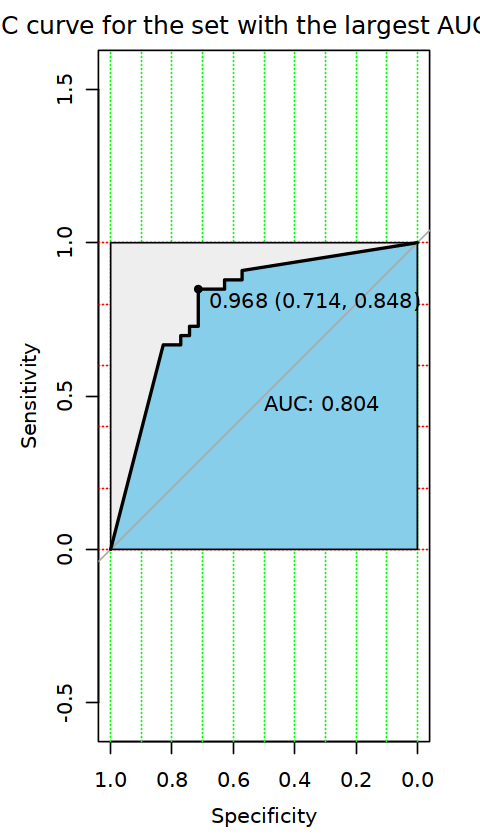

In [246]:
roc_curve <- pROC::roc(as.numeric(fold_test$Group),fold_predict)
plot(roc_curve, print.auc=TRUE, auc.polygon=TRUE, grid=c(0.1, 0.2),
     grid.col=c("green", "red"), max.auc.polygon=TRUE,
     auc.polygon.col="skyblue", print.thres=TRUE,main="ROC curve for the set with the largest AUC value")

In [247]:
library(ROCR)

dd<-datadist(data)  #开始打包数据
options(datadist="dd")

data$Group = as.factor(data$Group)

fit1 <- lrm(Group~AC132872.2+NEK2+CCNA2+SAP130 , data=data,x=T,y=T)


fit1

#  https://blog.csdn.net/Ayue0616/article/details/126601832

# cal1 <- calibrate(fit1, method='boot', B=1000) 
# plot(cal1,xlim=c(0,1.0),ylim=c(0,1.0))

### https://blog.51cto.com/u_15172991/5428282  模型图的解释参考链接

# https://ayueme.github.io/R_clinical_model/nomogram-essential.html

# https://blog.csdn.net/Dr_long1996/article/details/135446784

save(fit1,data,file = 'train.fit1.rda')

#列线图代码只能在Rstudio话

# library('regplot')
# regplot(fit1,
#         plots = c("violin", "boxes"), ##连续性变量形状，可选"no plot" "density" "boxes" "ecdf" "bars" "boxplot" "violin" "bean" "spikes"；分类变量的形状，可选"no plot" "boxes" "bars" "spikes"
#         observation = data[1,], #用哪行观测，或者T F
#         center = T, # 对齐变量
#         subticks = T,
#         droplines = T,#是否画竖线
#         title = "nomogram",
#         points = T, # 截距项显示为0-100
#         odds = T, # 是否显示OR值
#         showP = T, # 是否显示变量的显著性标记
#         rank = "sd", # 根据sd给变量排序
#         interval="confidence", # 展示可信区间
#         clickable = F # 是否可以交互
# )

Logistic Regression Model

lrm(formula = Group ~ AC132872.2 + NEK2 + CCNA2 + SAP130, data = data, 
    x = T, y = T)

                       Model Likelihood     Discrimination    Rank Discrim.    
                             Ratio Test            Indexes          Indexes    
Obs            85    LR chi2      59.37     R2       0.670    C       0.927    
 1             43    d.f.             4     R2(4,85) 0.479    Dxy     0.854    
 0             42    Pr(> chi2) <0.0001    R2(4,63.7)0.581    gamma   0.855    
max |deriv| 7e-08                           Brier    0.115    tau-a   0.432    

           Coef     S.E.   Wald Z Pr(>|Z|)
Intercept   15.0083 3.4430  4.36  <0.0001 
AC132872.2  -4.0132 1.4002 -2.87  0.0042  
NEK2       -13.5900 6.0391 -2.25  0.0244  
CCNA2       -2.6275 0.9592 -2.74  0.0062  
SAP130      -0.5966 0.1819 -3.28  0.0010  


In [253]:
fit.reduce <- glm(Group~AC132872.2+NEK2+CCNA2+SAP130,data=data,family=binomial())

In [254]:
fit.result<-summary(fit.reduce)
df1<-fit.result$coefficients
df2<-confint(fit.reduce)
df3<-cbind(df1,df2)
df4<-data.frame(df3[-1,c(1,4,5,6)])
df4$Var<-rownames(df4)
colnames(df4)<-c("OR","Pvalue","OR_1","OR_2","Var")
df5<-df4[,c(5,1,2,3,4)]
df5$OR_mean<-df5$OR
df5$OR<-paste0(round(df5$OR,2),
               "(",
               round(df5$OR_1,2),
               "~",
               round(df5$OR_2,2),
               ")")
df5$Pvalue<-round(df5$Pvalue,3)
write.csv(df5,file = "forestplot_example.csv",
          quote = F,row.names = F)


Waiting for profiling to be done...



In [293]:
df5

,Var,OR,Pvalue,OR_1,OR_2,OR_mean
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AC132872.2,AC132872.2,-4.01(-7.18~-1.59),0.004,-7.1788921,-1.5913535,-4.0131795
NEK2,NEK2,-13.59(-26.72~-2.64),0.024,-26.7179089,-2.6406154,-13.5899731
CCNA2,CCNA2,-2.63(-4.71~-0.92),0.006,-4.7092999,-0.9221778,-2.6275058
SAP130,SAP130,-0.6(-1~-0.27),0.001,-0.9963749,-0.2713556,-0.5965813


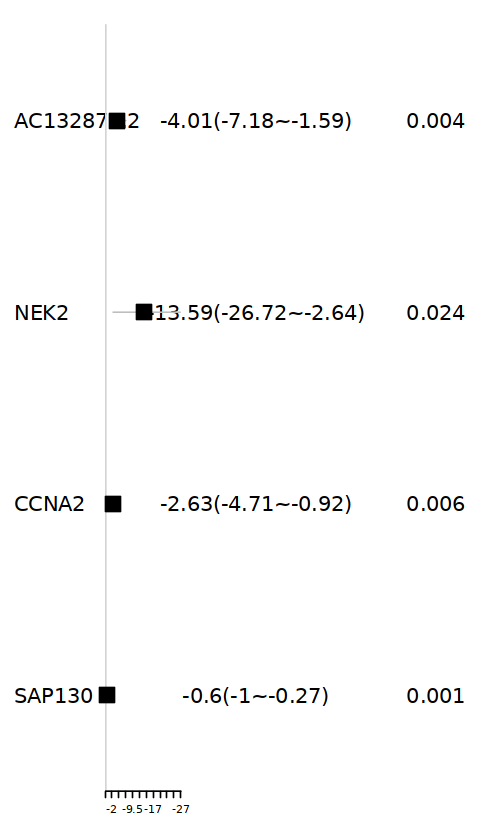

In [255]:

library(forestplot)
fp<-read.csv("forestplot_example.csv",header=T)

forestplot(labeltext=as.matrix(fp[,1:3]),
           mean=fp$OR_mean,
           lower=fp$OR_1,
           upper=fp$OR_2,
           zero=0,
           boxsize=0.2,
           graph.pos=2)

In [294]:
library("autoReg")


Attaching package: 'autoReg'


The following object is masked from 'package:MASS':

    select




In [302]:
overall.log =  glm(Group~AC132872.2+NEK2+CCNA2+SAP130,data=data,family=binomial())

In [303]:
model3<-autoReg(overall.log,uni=TRUE,milti=TRUE,threshold=0.05)

In [304]:
model3

name,desc,1 (N=43),0 (N=42),id,OR (univariable),OR (multivariable)
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AC132872.2,Mean <U+00B1> SD,0.7 <U+00B1> 0.3,0.5 <U+00B1> 0.2,AC132872.2,"0.05 (0.01-0.32, p=.001)","0.02 (0.00-0.28, p=.004)"
NEK2,Mean <U+00B1> SD,0.1 <U+00B1> 0.1,0.1 <U+00B1> 0.1,NEK2,"0.00 (0.00-0.01, p=.002)","0.00 (0.00-0.17, p=.024)"
CCNA2,Mean <U+00B1> SD,1.6 <U+00B1> 0.8,1.0 <U+00B1> 0.4,CCNA2,"0.05 (0.01-0.23, p<.001)","0.07 (0.01-0.47, p=.006)"
SAP130,Mean <U+00B1> SD,15.0 <U+00B1> 3.2,12.3 <U+00B1> 1.8,SAP130,"0.58 (0.45-0.76, p<.001)","0.55 (0.39-0.79, p=.001)"


In [ ]:
# forestplot(labeltext=as.matrix(fp[,1:3]),
#            mean=fp$OR_mean,
#            lower=fp$OR_1,
#            upper=fp$OR_2,
#            zero=0,
#            boxsize=0.2,
#            lineheight = unit(7,'mm'),
#            colgap=unit(2,'mm'),
#            lwd.zero=1.5,
#            lwd.ci=2, 
#            col=fpColors(box='#458B00',
#                         summary='#8B008B',
#                         lines = 'black',
#                         zero = '#7AC5CD'),
#            xlab="OR",
#            lwd.xaxis =1,
#            txt_gp = fpTxtGp(ticks = gpar(cex = 0.85),
#                             xlab  = gpar(cex = 0.8),
#                             cex = 0.9),
#            lty.ci = "solid",
#            title = "Forestplot", 
#            line.margin = 0.08,
#            graph.pos=2)


In [ ]:
#nmfinput= data[MDD,c('MYRF','IGHJ3P','RBMS1P1','CTD.2114J12.1')] %>%  t() %>%  as.data.frame()

In [ ]:
library(NMF)

In [ ]:
ranks <- 1:10
estim.coad <- nmf(nmfinput,ranks, nrun=10)
duplicated(colnames(nmfinput))

In [ ]:
plot(estim.coad)

In [ ]:
seed = 2020820
nmf.rank4 <- nmf(nmfinput, 
                 rank = 2, 
                 nrun=50,
                 seed = seed, 
                 method = "brunet")

In [ ]:
jco <- c("#EABF00","#C6524A","#868686")
index <- extractFeatures(nmf.rank4,"max") 
sig.order <- unlist(index)
NMF.Exp.rank4 <- nmfinput[sig.order,]
NMF.Exp.rank4 <- na.omit(NMF.Exp.rank4) #sig.order有时候会有缺失值
group <- predict(nmf.rank4) # 提出亚型
table(group)
consensusmap(nmf.rank4,
             labRow = NA,
             labCol = NA,
             annCol = data.frame("cluster"=group[colnames(NMF.Exp.rank4)]),
             annColors = list(cluster=c("1"=jco[1],"2"=jco[2])))

In [ ]:
library(tinyarray)

In [ ]:
data1 = data[MDD,-1] %>%  t() %>% as.data.frame()

In [ ]:
a = data1[,colnames(nmfinput)]

In [ ]:
cg=names(tail(sort(apply(a,1,sd)),12000))
n=a[cg,]

In [ ]:
draw_pca(n,group)

In [ ]:
library(Rtsne)
tsne_out = Rtsne(t(n),perplexity = 1)
pdat = data.frame(tsne_out$Y,factor(group))
colnames(pdat) = c("Y1","Y2","group")
head(pdat)

In [ ]:
pdat1 = pdat %>% tibble::rownames_to_column(.,'sample')

In [ ]:
bulk2.group = pdat1[,c(1,4)]
write.csv(bulk2.group,file = 'bulk2.group.csv',row.names =F)

In [ ]:
dim(bulk2.group)

In [ ]:
library(ggplot2)
library(paletteer)
ggplot(pdat,aes(Y1,Y2))+
  geom_point(aes(Y1,Y2,fill = group),shape = 21,color = "black")+
  stat_ellipse(aes(color = group,fill = group),
               geom = "polygon",
               alpha = 0.3,
               linetype = 2)+
  scale_color_paletteer_d("RColorBrewer::Set2")+
  scale_fill_paletteer_d("RColorBrewer::Set2")+
  theme_classic()+
  theme(legend.position = "top")